In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
plt.rcParams['font.size'] = 14

In [16]:
def read_auc(logfile, mode='valid'):
    linenum = -1 if mode == 'test' else -4
    with open(logfile, 'r') as f:
        line = f.readlines()[linenum]
        return float(line[30:37])
    
def read_ce(logfile, mode='valid'):
    linenum = -2 if mode == 'test' else -5
    with open(logfile, 'r') as f:
        line = f.readlines()[linenum]
        return float(line[23:30])
    
def read_r2(logfile, mode='valid'):
    linenum = -1 if mode == 'test' else -4
    with open(logfile, 'r') as f:
        line = f.readlines()[linenum]
        return float(line[9:16])

In [19]:
read_ce("/project/rcde/datasets/pda/model_run_artifacts/MICCAI_pda_numheads_16/log.txt")

0.44978

In [14]:
len("	Cross entropy loss = ")

22

In [13]:
!cat /project/rcde/datasets/pda/model_run_artifacts/MICCAI_pda_numheads_16/log.txt

Running training script with configuration:
------------------------------
artifact_folder: /project/rcde/datasets/pda/model_run_artifacts/MICCAI_pda_numheads_16/
dataloader_kwargs:
  batch_size: 20
  num_workers: 45
  pin_memory: true
dataset_kwargs:
  mode_filter:
  - color
  - color_compare
  view_filter:
  - pdaRelatedView
  - pdaView
device: cuda:0
early_stopper_kwargs:
  patience: 10
encoder_kwargs:
  checkpoint: null
  checkpoint_path: null
  in_chans: 3
  model_name: resnet50d
  pretrained: true
frame_csv: /project/rcde/datasets/pda/model_data/pda_train_val_test.csv
num_epochs: 200
optim_kwargs:
  lr: 0.0001
  weight_decay: 0.001
res: 112
sched_kwargs:
  factor: 0.1
  patience: 3
  verbose: true
subset_column: null
time_downsample_kwargs:
  method: random
  num_frames: 32
vidnet_kwargs:
  drop_rate: 0.5
  num_heads: 16
  num_out: 1
  pooling_method: attn
------------------------------
Creating video classifier network.
Number of trainable params: 23531361 (4097 excluding encode

# Test Set Performance for Table

In [4]:
print("PDA Classification Performance (ROC AUC)")
print("R(2+1)D:", 0.816)
print("Avg. pool:", f"{read_auc('/zfs/wficai/pda/model_run_artifacts/pda_avg/log.txt', mode='test'):0.3f}")
print("Max pool:", f"{read_auc('/zfs/wficai/pda/model_run_artifacts/pda_max/log.txt', mode='test'):0.3f}")
print("Ours:", f"{read_auc('/zfs/wficai/pda/model_run_artifacts/pda_patient_sample_44/log.txt', mode='test'):0.3f}")

print("\nEchoNet Ejection Fraction Performance (R^2)")
print("R(2+1)D:", 0.822)
print("Avg. pool:", f"{read_r2('/zfs/wficai/pda/model_run_artifacts/echonet_pool_avg/log.txt', mode='test'):0.3f}")
print("Max pool:", f"{read_r2('/zfs/wficai/pda/model_run_artifacts/echonet_pool_max/log.txt', mode='test'):0.3f}")
print("Ours:", f"{read_r2('/zfs/wficai/pda/model_run_artifacts/echonet_numheads_128/log.txt', mode='test'):0.3f}")

PDA Classification Performance (ROC AUC)
R(2+1)D: 0.816
Avg. pool: 0.837
Max pool: 0.835
Ours: 0.855

EchoNet Ejection Fraction Performance (R^2)
R(2+1)D: 0.822
Avg. pool: 0.679
Max pool: 0.657
Ours: 0.765


# Attention head plot

In [5]:
num_heads = [2**n for n in range(12)]

In [22]:
# PDA classification performance
perf_pda_nh = []
nh_pda = []
for n in num_heads:
    try:
        file = f'/project/rcde/datasets/pda/model_run_artifacts/pda_numheads_{n}/log.txt'
        #file = f'/zfs/wficai/pda/model_run_artifacts/MICCAI_pda_radimagenet_numheads_{n}/log.txt'
        perf_pda_nh.append(read_ce(file, mode='test'))
        nh_pda.append(n)
    except Exception as e:
        print(n, e)   
        
perf_pda_nh_scaled = []
nh_pda_scaled = []
for n in num_heads:
    try:
        file = f'/zfs/wficai/pda/model_run_artifacts/pda_numheads_{n}/log.txt'
        perf_pda_nh_scaled.append(read_ce(file))
        nh_pda_scaled.append(n)
    except Exception as e:
        print(n, e)   
        
perf_pda_maxpool = read_ce('/zfs/wficai/pda/model_run_artifacts/pda_max/log.txt')
perf_pda_avgpool = read_ce('/zfs/wficai/pda/model_run_artifacts/pda_avg/log.txt')

# EchoNet performance
perf_echo_nh = []
nh_echo = []
for n in num_heads:
    try: 
        file =  f'/zfs/wficai/pda/model_run_artifacts/echonet_numheads_{n}/log.txt'
        perf_echo_nh.append(read_r2(file))
        nh_echo.append(n)
    except Exception as e:
        print(n, e)
        
# EchoNet performance
perf_echo_nh_tanh = []
nh_echo_tanh = []
for n in num_heads:
    try: 
        file =  f'/zfs/wficai/pda/model_run_artifacts/echonet_numheads_{n}/log.txt'
        perf_echo_nh_tanh.append(read_r2(file))
        nh_echo_tanh.append(n)
    except Exception as e:
        print(n, e)
        
perf_echo_maxpool = read_r2('/zfs/wficai/pda/model_run_artifacts/echonet_pool_max/log.txt')
perf_echo_avgpool = read_r2('/zfs/wficai/pda/model_run_artifacts/echonet_pool_avg/log.txt')

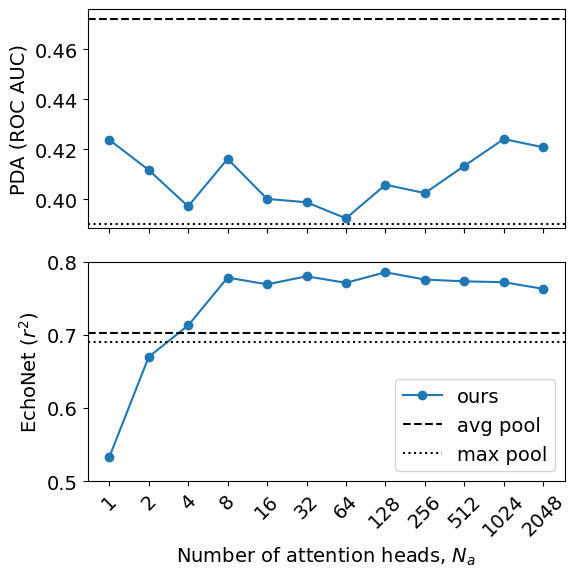

In [23]:
fig, (ax_pda, ax_echo) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(6,6)

ax_pda.plot(nh_pda, perf_pda_nh, 'o-', label='ours')
# ax_pda.plot(nh_pda_scaled, perf_pda_nh_scaled, 'ro-', label='scaled dot prod')
ax_pda.semilogx()
ax_pda.minorticks_off()
ax_pda.set_xticks(ticks=num_heads)
ax_pda.set_xticklabels(labels=num_heads, rotation=45)
ax_pda.axhline(y=perf_pda_avgpool, label="avg pool", color='k', linestyle='--')
ax_pda.axhline(y=perf_pda_maxpool, label="max pool", color='k', linestyle=':')
ax_pda.set_ylabel('PDA (ROC AUC)')

ax_echo.plot(nh_echo, perf_echo_nh, 'o-', label='ours')
ax_echo.semilogx()
ax_echo.minorticks_off()
ax_echo.set_xticks(ticks=num_heads)
ax_echo.set_yticks(ticks=np.linspace(0.5, 0.8, 4))
ax_echo.set_xticklabels(labels=num_heads, rotation=45)
ax_echo.axhline(y=perf_echo_avgpool, label="avg pool", color='k', linestyle='--')
ax_echo.axhline(y=perf_echo_maxpool, label="max pool", color='k', linestyle=':')
ax_echo.set_xlabel(r'Number of attention heads, $N_a$')
ax_echo.set_ylabel(r'EchoNet ($r^2$)')
ax_echo.legend(loc=4)

plt.tight_layout()
plt.savefig('../../paper/num_heads.png', dpi=500)

# Num videos plots

### PDA data

In [8]:
# our runs
runs = ['pda_patient_sample_5', 'pda_patient_sample_12', 'pda_patient_sample_20', 'pda_patient_sample_28', 'pda_patient_sample_36',  'pda_patient_sample_44']
# runs = ['pda_radimagenet_patient_sample_5', 'pda_radimagenet_patient_sample_12', 'pda_radimagenet_patient_sample_20', 'pda_radimagenet_patient_sample_28', 'pda_radimagenet_patient_sample_36',  'pda_radimagenet_patient_sample_44']
num   = np.array([5, 12, 20, 28, 36, 44])
num_vids = np.array([46, 143, 258, 465, 621, 755])
tick_labs = [f"{nv}({n})" for n, nv in zip(num, num_vids)]

aucs = []
for n in num:
    try:
        #MICCAI_pda_numpatients_patient_sample_5
        logfile = f'/project/rcde/datasets/pda/model_run_artifacts/MICCAI_pda_numpatients_patient_sample_{n}/log.txt'
        aucs.append(read_auc(logfile, mode='test'))
    except Exception as e:
        print(e)

aucs = np.array(aucs)

# theirs R(2+1)d
auc_2 = np.array([0.612136402, 0.721804511, 0.738740791, 0.794410268, 0.783170046, 0.815675553])

# avg pooling
runs = ['pda_patient_sample_5_avgpool', 'pda_patient_sample_12_avgpool', 'pda_patient_sample_20_avgpool', 'pda_patient_sample_28_avgpool', 'pda_patient_sample_36_avgpool',  'pda_patient_sample_44_avgpool']

aucs_avgpool = []
for f in runs:
    logfile = f'/project/rcde/datasets/pda/model_run_artifacts/{f}/log.txt'
    aucs_avgpool.append(read_auc(logfile, mode='test'))
aucs_avgpool = np.array(aucs_avgpool)

# max pooling
runs = ['pda_patient_sample_5_maxpool', 'pda_patient_sample_12_maxpool', 'pda_patient_sample_20_maxpool', 'pda_patient_sample_28_maxpool', 'pda_patient_sample_36_maxpool',  'pda_patient_sample_44_maxpool']

aucs_maxpool = []
for f in runs:
    logfile = f'/zfs/wficai/pda/model_run_artifacts/{f}/log.txt'
    aucs_maxpool.append(read_auc(logfile, mode='test'))
aucs_maxpool = np.array(aucs_maxpool)

### EchoNet data

In [9]:
# get attention pooling runs
runs = ['echonet_train_fullval_test_0.01.csv', 
         'echonet_train_fullval_test_0.05.csv', 
         'echonet_train_fullval_test_0.1.csv', 
         'echonet_train_fullval_test_0.25.csv', 
         'echonet_train_fullval_test_0.5.csv',  
         'echonet_train_fullval_test_0.75.csv',
         'echonet_numheads_8']

dec = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
num_vids = [74, 373, 746, 1866, 3732, 5598, 7465]

# ours
r2s = []
for f in runs:
    logfile = f'/zfs/wficai/pda/model_run_artifacts/{f}/log.txt'
    r2s.append(read_r2(logfile, mode='test'))
r2s = np.array(r2s)

# theirs R(2+1)d
r2s_r21d = np.array([0.116, 0.458, 0.548, 0.743, 0.782, 0.792, 0.822])

# get avg pooling runs
runs_avg = ['echonet_train_fullval_test_0.01.csv_avgpool', 
         'echonet_train_fullval_test_0.05.csv_avgpool', 
         'echonet_train_fullval_test_0.1.csv_avgpool', 
         'echonet_train_fullval_test_0.25.csv_avgpool', 
            'echonet_train_fullval_test_0.5.csv_avgpool',
            'echonet_train_fullval_test_0.75.csv_avgpool',
            'echonet_pool_avg']

# ours
r2s_avg = []
for f in runs_avg:
    logfile = f'/zfs/wficai/pda/model_run_artifacts/{f}/log.txt'
    r2s_avg.append(read_r2(logfile, mode='test'))
r2s_avg = np.array(r2s_avg)

### Plot

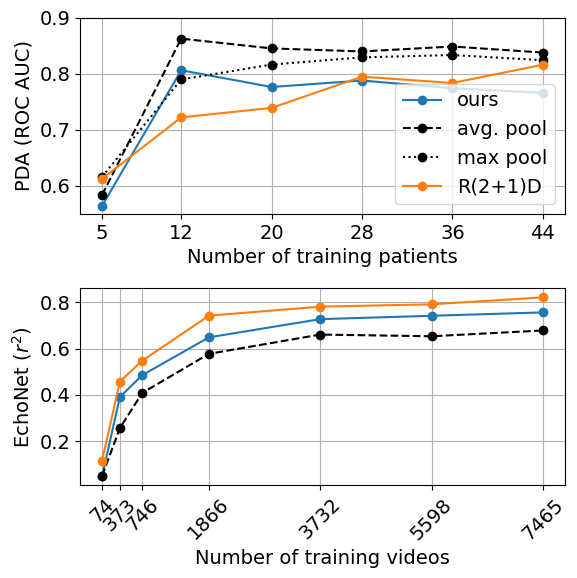

In [10]:
fig, (ax_pda, ax_echo) = plt.subplots(nrows=2, ncols=1, sharex=False)
fig.set_size_inches(6,6)

# pda plot
ax_pda.plot(num, aucs, 'o-', label='ours')
ax_pda.plot(num, aucs_avgpool, 'o--', color='k', label="avg. pool")
ax_pda.plot(num, aucs_maxpool, 'o:', color='k', label="max pool")
ax_pda.plot(num, auc_2, 'o-', label='R(2+1)D')
ax_pda.set_xlabel('Number of training patients')
ax_pda.set_xticks(ticks=num, labels=num)    
ax_pda.set_ylabel('PDA (ROC AUC)')
ax_pda.legend(loc=4)
ax_pda.set_ylim(None, 0.9)
ax_pda.grid()

# echonet plot
ax_echo.plot(dec, r2s, 'o-', label='ours')
ax_echo.plot(dec, r2s_avg, 'ko--', label='avg. pool')
ax_echo.plot(dec, r2s_r21d, 'o-', label='R(2+1)D')
ax_echo.set_xlabel('Number of training videos')
ax_echo.set_xticks(ticks=dec, labels=num_vids, rotation=45)
ax_echo.set_ylabel(r'EchoNet ($r^2$)')
ax_echo.grid()

plt.tight_layout()
plt.savefig('../../paper/data_size.png', dpi=500)